# Transformer-Based Time-to-Failure prediction for plane engine with NASA C-MAPSS multivariate timeseries

## Import dependencies

In [1]:
# !pip install -r requirements.txt

In [2]:
# Built-in libraries
import os
import json
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget
# Constants
from src.constants import TRAIN_FILES, TEST_FILES, RUL_FILES, WINDOW_SIZE, PRETRAIN_EPOCHS, SCALER_PATH, SCALER_FULL_PATH
# Preprocessing
from src.preprocessing import scale, denoise, remove_features, windowing
from src.open_files import open_train_val, open_test
# Postprocessing
from src.postprocessing import align, aggregate
# Models
from src.ml import train_lr, train_rf, predict as predict_ml
from src.encoder import train as train_enc, predict as predict_enc
from src.lstm import train as train_lstm, predict as predict_lstm


## Model choice

In [ ]:
Training = True # Set to true if you want to train a new model
MODEL_INDEX = 0 # Define here the model you want to use, see list just below
WINDOW_SIZE = WINDOW_SIZE # You can change these two parameters if you want to, optimal value is 19
PRETRAIN_EPOCHS = PRETRAIN_EPOCHS # (Only for encoders), optimal value is 3. If 0, skip the pretraining.

models = [
    "ENCDL", # The final solution, an encoder regressor with a learned positional encoding
    "ENCDS", # An encoder regressor with a static positional encoding
    "LSTM", # An LSTM NN
    "RF", # A Random Forest model, This on NEEDS to be retrained as it is too big to be stored on github.
    "LR", # A linear regressor,
    "ENCDRLfull", # The final solution but trained on all 4 files
]

model_paths = { # The path where the model are saved
    "ENCDL" : f"saved_models/encdl-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}.model",
    "ENCDS" : f"saved_models/encds-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}.model",
    "LSTM" : f"saved_models/lstm-{WINDOW_SIZE}.keras",
    "RF" : f"saved_models/rforest-{WINDOW_SIZE}.skl",
    "LR" : f"saved_models/lregression-{WINDOW_SIZE}.skl",
    "ENCDRLfull" : f"saved_models/encd-full-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}.model",
}

model_train_functions = { # The function to call to train the model
    "ENCDL" : lambda *args: train_enc(*args, True, PRETRAIN_EPOCHS),
    "ENCDS" : lambda *args: train_enc(*args, False, PRETRAIN_EPOCHS),
    "LSTM" : train_lstm,
    "RF" : train_rf,
    "LR" : train_lr,
    "ENCDRLfull" : lambda *args: train_enc(*args, True, PRETRAIN_EPOCHS)
}

model_test_functions = { # The function to call to test the model
    "ENCDL" : lambda *args: predict_enc(*args, True),
    "ENCDS" : lambda *args: predict_enc(*args, False),
    "LSTM" : predict_lstm,
    "RF" : predict_ml,
    "LR" : predict_ml,
    "ENCDRLfull" : lambda *args: predict_enc(*args, True)
}

model_result_paths =  { # The path where to save the results of the test.
    "ENCDL" : f"results/encdl-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}",
    "ENCDS" : f"results/encds-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}",
    "LSTM" : f"results/lstm-{WINDOW_SIZE}",
    "RF" : f"results/rf-{WINDOW_SIZE}",
    "LR" : f"results/lr-{WINDOW_SIZE}",
    "ENCDRLfull" : f"results/full-{WINDOW_SIZE}-{PRETRAIN_EPOCHS}"
}

model_full_dataset = { # Whether the full dataset is to be used or only the first file
    "ENCDL" : False,
    "ENCDS" : False,
    "LSTM" : False,
    "RF" : False,
    "LR" : False,
    "ENCDRLfull" : True
}

# Define the constants based on the model choice.
MODEL = models[MODEL_INDEX]
PATH = model_paths[MODEL]
TRAIN_FUNC = model_train_functions[MODEL]
TEST_FUNC = model_test_functions[MODEL]
SAVE_PATH = model_result_paths[MODEL]
full_dataset = model_full_dataset[MODEL]
TRAIN_FILES = TRAIN_FILES if full_dataset else TRAIN_FILES[0:1]
TEST_FILES = TEST_FILES if full_dataset else TEST_FILES[0:1]
RUL_FILES = RUL_FILES if full_dataset else RUL_FILES[0:1]

# Show a summary of the choice.
print("Summary:")
print("Chosen model:", MODEL)
print("Path of the model:", PATH)
print("Path to save the results:", SAVE_PATH)
print("Dataset used:", "ALL" if full_dataset else "First subset")
print("Window size:", WINDOW_SIZE)
if MODEL.startswith('ENCD'):
    print('Pretraining epochs:', PRETRAIN_EPOCHS)
print("Requested training:", Training)

if not os.path.isfile(PATH) and not Training:
    existing = os.listdir("./saved_models")
    existing.remove("scaler.skl")
    existing.remove("full_scaler.skl")
    raise ValueError(f"""The model {PATH} does not exist yet, please chose an existing model or train it.\n Existing models: {existing}""")

Summary:
Chosen model: LR
Path of the model: saved_models/lregression-7.skl
Path to save the results: results/lr-7
Dataset used: First subset
Window size: 7
Requested training: True


## Train

In [4]:
if Training:
    # Preprocessing
    df_train, df_val = open_train_val(TRAIN_FILES)
    df_train = scale(denoise(remove_features(df_train)), True, SCALER_FULL_PATH if full_dataset else SCALER_PATH)
    df_val = scale(denoise(remove_features(df_val)), False, SCALER_FULL_PATH if full_dataset else SCALER_PATH)
    X_train, y_train, _tids_train, _cycles_train = windowing(df_train, WINDOW_SIZE)
    X_val, y_val, tids_val, cycles_val = windowing(df_val, WINDOW_SIZE)
    print("End of preprocessing, training starts.")
    # Training
    TRAIN_FUNC(X_train, y_train, X_val, y_val, PATH)
    print("Training successful.")
    # Evaluate on the validation dataset
    y_val_pred = TEST_FUNC(X_val, PATH)
    df_pred = align(y_val_pred, cycles_val, tids_val)
    val_ruls, y = aggregate(df_pred, y_val)
    short_rul = y < 20
    print("Overall Validation RMSE:", np.sqrt(np.mean((val_ruls - y)**2)))
    print("Validation RMSE <20:", np.sqrt(np.mean((val_ruls - y)[short_rul]**2)))
    print("Validation RMSE >20:", np.sqrt(np.mean((val_ruls - y)[~short_rul]**2)))

End of preprocessing, training starts.
Training successful.
Overall Validation RMSE: 24.74212126418939
Validation RMSE <20: 24.74212126418939
Validation RMSE >20: nan


c:\Users\tangu\Tanguy\Études\Polito S3\Data Science Project\2024-P12-TTF\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\tangu\Tanguy\Études\Polito S3\Data Science Project\2024-P12-TTF\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Test

In [5]:
preds = []
targets = []
for test_file, rul_file in zip(TEST_FILES, RUL_FILES): # we use a for loop to test the files 1 by 1 to avoid memory problems.
    df_test = open_test([test_file], [rul_file])
    df_test = scale(denoise(remove_features(df_test)), False, SCALER_FULL_PATH if full_dataset else SCALER_PATH)
    X_test, y_test, tids_test, cycles_test = windowing(df_test, WINDOW_SIZE)
    y_test_pred = TEST_FUNC(X_test, PATH)
    df_pred = align(y_test_pred, cycles_test, tids_test)
    test_ruls, y = aggregate(df_pred, y_test)
    preds.append(test_ruls)
    targets.append(y)
test_ruls = np.hstack(preds)
y = np.hstack(targets)
short_rul = y < 20
print("Overall Test RMSE:", np.sqrt(np.mean((test_ruls - y)**2)))
print("Test RMSE <20:", np.sqrt(np.mean((test_ruls - y)[short_rul]**2)))
print("Test RMSE >20:", np.sqrt(np.mean((test_ruls - y)[~short_rul]**2)))

Overall Test RMSE: 34.67954382627308
Test RMSE <20: 26.74582824058048
Test RMSE >20: 35.71400844516737


## Save results

In [6]:
os.makedirs('results', exist_ok=True)
os.makedirs(f'{SAVE_PATH}', exist_ok=True)

# Save the results
with open(SAVE_PATH + '/RUL.json', 'w') as f:
    json.dump(list(test_ruls), f)

with open(SAVE_PATH + '/targets.json', 'w') as f:
    json.dump(list(y.astype(float)), f)

with open(SAVE_PATH + '/bywindow.json', 'w') as f:
    json.dump(
        {'pred' : list(y_test_pred.astype(float)),
         'tids' : list(tids_test),
         'cycles': list(cycles_test.astype(float)),
         'truth' : list(y_test.astype(float))
        }, f)

## Visualize results

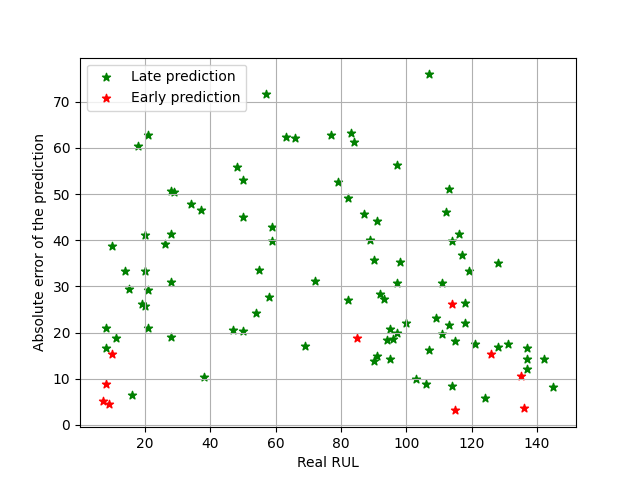

In [7]:
df = pd.DataFrame({'targets' : y, 'results' : test_ruls})
df["errors"] = df['targets'] - df['results']
plt.scatter(df['targets'][df['errors'] <= 0], -df['errors'][df['errors'] <= 0], c='g', marker='*')
plt.scatter(df['targets'][df['errors'] > 0], df['errors'][df['errors'] > 0], c='r', marker='*')
plt.grid()
plt.xlabel("Real RUL")
plt.ylabel("Absolute error of the prediction")
plt.legend(['Late prediction', 'Early prediction'])
plt.show()